In [1]:
import pickle as pkl
import os 
import sys
import numpy as np
from xopen import xopen
import time
import json
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

from torch_geometric.data import GraphSAINTRandomWalkSampler, NeighborSampler

def simMatrix(A: torch.tensor, B: torch.tensor) -> torch.tensor:
    # Assume A and B are your input tensors of shape (N, d)
    # Example: A = torch.randn(N, d)
    #          B = torch.randn(N, d)

    # Step 1: Normalize A and B
    A_norm = A / A.norm(dim=1, keepdim=True)
    B_norm = B / B.norm(dim=1, keepdim=True)

    # Step 2: Compute the dot product
    cosine_similarity_matrix = torch.mm(A_norm, B_norm.transpose(0, 1))

    # The resulting cosine_similarity_matrix is of shape (N, N)
    # and contains values in the range [-1, 1]
    return cosine_similarity_matrix

Dataset_name = "sports"
DATA_PATH = f"/home/ubuntu/proj/data/graph/node_{Dataset_name}"
DATA_NAME = f"text_graph_{Dataset_name}" # "text_graph_pubmed" #"text_graph_aids" #"text_graph_pubmed" # # 
SAVE_DIR = f"/home/ubuntu/proj/code/axolotl_softprompt/data/{Dataset_name}"
TRAIN_SPLIT_NAME = 'train_index'
VALID_SPLIT_NAME = 'valid_index'
TEST_SPLIT_NAME = 'test_index'

with open(os.path.join(DATA_PATH, f"{DATA_NAME}.pkl"), 'rb') as f:
    graph = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TRAIN_SPLIT_NAME}.pkl"), 'rb') as f:
    train_split = pkl.load(f)

with open(os.path.join(DATA_PATH, f"{VALID_SPLIT_NAME}.pkl"), 'rb') as f:
    valid_split = pkl.load(f)
with open(os.path.join(DATA_PATH, f"{TEST_SPLIT_NAME}.pkl"), 'rb') as f:
    test_split = pkl.load(f)

k = 2


/home/ubuntu/anaconda3/envs/graphllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_levels_embedding = dict()
encoder_type = 'angle'
for relevance_type in ['pos']:
    all_levels_embedding[relevance_type] = dict()
    # build 0-order textual-graph
    text_nodes = graph.text_nodes
    edge_index = graph.edge_index
    k = 2
 
    for order in range(0, k+1):
        if encoder_type == 'bert':
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}-bert.pt")).squeeze(-2)
        else:
            all_levels_embedding[relevance_type][order] = torch.load(os.path.join(DATA_PATH, relevance_type, f"order-{order}-angle.pt")).squeeze(-2)

In [3]:
relevance_type_all = 'all'
all_levels_embedding[relevance_type_all] = dict()
k = 2

for order in range(0, k+1):
    all_levels_embedding[relevance_type_all][order] = torch.stack(
        [all_levels_embedding[relevance_type][order] for relevance_type in ['pos']]
        ).mean(axis=0)


In [4]:
from gnn import GCN, SAGE
relevance_type = 'pos'
device = torch.device('cuda:0')
num_features = 768 if encoder_type == 'bert' else 1024
hidden_channels = num_features
num_layers = 2
dropout = 0.5
gnn = 'gcn' #'sage' #'gcn'

if gnn == 'gcn':
    model = GCN(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)
elif gnn == 'sage':
    model = SAGE(num_features, hidden_channels,
                num_features, num_layers,
                dropout).to(device)

lr = 1e-3
num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
sampler_data = Data(
    x = all_levels_embedding[relevance_type][0],
    text_embed_1 = all_levels_embedding[relevance_type][1],
    text_embed_2 = all_levels_embedding[relevance_type][2],
    edge_index = graph.edge_index
)

In [6]:
batch_size = 256
walk_length = 5
num_steps = 100

if not os.path.exists(os.path.join(DATA_PATH, 'sampled')):
    os.makedirs(os.path.join(DATA_PATH, 'sampled'))
loader = GraphSAINTRandomWalkSampler(sampler_data,
                                     batch_size=batch_size,
                                     walk_length=walk_length,
                                     num_steps=num_steps,
                                     sample_coverage=50,
                                     num_workers=32,
                                     save_dir=os.path.join(DATA_PATH, 'sampled'),
                                     shuffle=True)

/home/ubuntu/anaconda3/envs/graphllm/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.GraphSAINTRandomWalkSampler' is deprecated, use 'loader.GraphSAINTRandomWalkSampler' instead
  warnings.warn(out)
Compute GraphSAINT normalization: : 8787236it [02:42, 54046.34it/s]                           


In [7]:
for batch_load in tqdm(loader):
    pass

100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


In [8]:

model.train()
corr_avg = dict()
for t in range(1, num_layers+1):
    corr_avg[t] = [[], []]
for epoch in range(1, 1 + num_epochs):
    start_time = time.time()
    loss_map_all = dict(zip(range(1, num_layers+1), [[] for _ in range(1, num_layers+1)]))
    for batch_load in (loader):
        x = batch_load.x.to(device)
        edge_index = batch_load.edge_index.to(device)
        embeddings_mapping = model.encode(x, edge_index)
        target = torch.eye(batch_load.num_nodes, device=device, dtype=torch.float)
        loss_map = {}
        for t in range(1, num_layers+1):
            corrmatrix = simMatrix(
                batch_load[f"text_embed_{num_layers}"].to(device),
                embeddings_mapping[t]
                )
            corr_avg[t][0].append(float(corrmatrix.diag().mean()))
            corr_avg[t][1].append(float(corrmatrix.mean()))
            loss_map[t] = criterion(corrmatrix.view(-1), target.view(-1))
            loss_map_all[t].append(float(loss_map[t]))
        loss = torch.sum(torch.stack([loss_map[i] for i in range(1, num_layers+1)]))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    executive_time = time.time() - start_time
    print(f"{epoch=}," + ",".join([f"order {i}: {np.mean(loss_map_all[i]):.4f}" for i in range(1, num_layers+1)]), "Time: {:.2f}".format(executive_time))

epoch=1,order 1: 19400.7921,order 2: 19416.8456 Time: 4.07
epoch=2,order 1: 19284.5855,order 2: 19327.3917 Time: 3.67
epoch=3,order 1: 19238.6597,order 2: 19281.8064 Time: 3.64
epoch=4,order 1: 19264.4089,order 2: 19307.4604 Time: 3.68
epoch=5,order 1: 19250.3667,order 2: 19292.5660 Time: 3.71
epoch=6,order 1: 19249.4030,order 2: 19291.1554 Time: 3.67
epoch=7,order 1: 19321.4302,order 2: 19363.4525 Time: 3.66
epoch=8,order 1: 19216.0731,order 2: 19257.9138 Time: 3.65
epoch=9,order 1: 19233.4933,order 2: 19275.6973 Time: 3.65
epoch=10,order 1: 19282.9075,order 2: 19325.5895 Time: 3.66
epoch=11,order 1: 19258.2663,order 2: 19300.9957 Time: 3.65
epoch=12,order 1: 19268.3646,order 2: 19311.1444 Time: 3.65
epoch=13,order 1: 19269.2659,order 2: 19312.5157 Time: 3.71
epoch=14,order 1: 19291.2988,order 2: 19334.8638 Time: 3.68
epoch=15,order 1: 19279.0798,order 2: 19322.7315 Time: 3.65
epoch=16,order 1: 19247.3094,order 2: 19291.1007 Time: 3.64
epoch=17,order 1: 19274.8611,order 2: 19318.8121 

In [9]:
batch_load

Data(num_nodes=1358, edge_index=[2, 5181], x=[1358, 1024], text_embed_1=[1358, 1024], text_embed_2=[1358, 1024], node_norm=[1358], edge_norm=[5181])

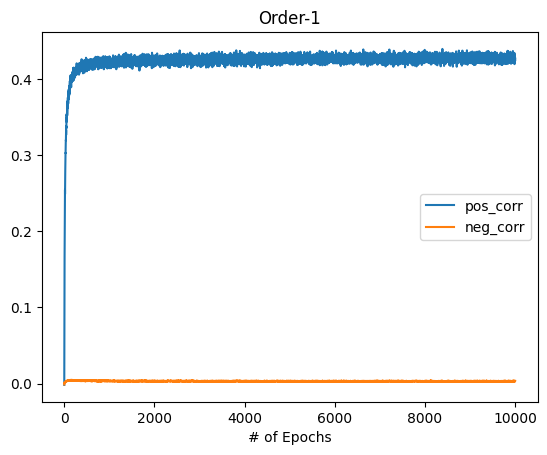

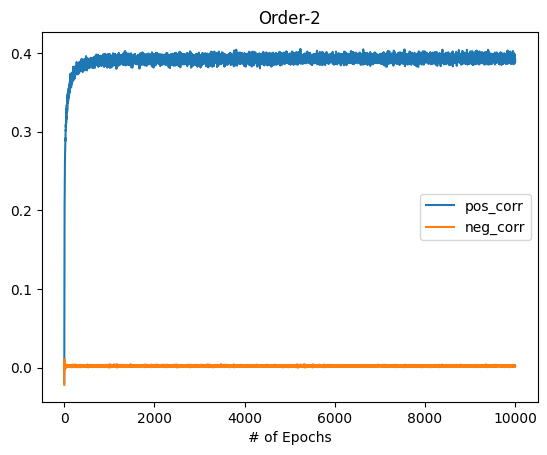

In [10]:
for t in range(1, num_layers+1):
    plt.plot(np.arange(num_epochs*num_steps), corr_avg[t][0])
    plt.plot(np.arange(num_epochs*num_steps), corr_avg[t][1])
    plt.legend(['pos_corr', 'neg_corr'])
    plt.xlabel('# of Epochs')
    plt.title(f'Order-{t}')
    plt.show()

In [11]:
from torch_geometric.loader import RandomNodeLoader
inference_loader = RandomNodeLoader(sampler_data, num_parts=graph.num_nodes // 5000, shuffle=False)

/home/ubuntu/anaconda3/envs/graphllm/lib/python3.11/site-packages/torch_geometric/data/storage.py:327: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'text_node_labels', 'edge_index', 'text_nodes'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [12]:
total_num = 0
embeddings_mapping = {1:[], 2:[]}
for batch_load in inference_loader:
    x = batch_load.x.to(device)
    edge_index = batch_load.edge_index.to(device)
    embeddings_mapping_item = model.encode(x, edge_index)
    for key in embeddings_mapping:
        embeddings_mapping[key].append(embeddings_mapping_item[key].detach().cpu())

for key in embeddings_mapping:
    embeddings_mapping[key] = torch.cat(embeddings_mapping[key])

In [13]:

if not os.path.exists(os.path.join(SAVE_DIR, relevance_type)):
    os.makedirs(os.path.join(SAVE_DIR, relevance_type))
embed = all_levels_embedding[relevance_type][0]
train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type, f'train_textual_order0-{encoder_type}.pt'))
torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order0-{encoder_type}.pt'))
torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order0-{encoder_type}.pt'))

for i in range(1, num_layers+1):
    # save textual BERT embeddings
    embed = all_levels_embedding[relevance_type][i]
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_textual_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_textual_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_textual_order{i}-{encoder_type}.pt'))

    # save GNN embeddings
    embed = embeddings_mapping[i].detach().cpu()
    train_pos_tokens, valid_pos_tokens, test_pos_tokens = embed[torch.tensor(train_split)], embed[torch.tensor(valid_split)], embed[torch.tensor(test_split)]
    train_pos_tokens = train_pos_tokens.view(-1, 1, num_features)
    valid_pos_tokens = valid_pos_tokens.view(-1, 1, num_features)
    test_pos_tokens = test_pos_tokens.view(-1, 1, num_features)
    torch.save(train_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'train_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(valid_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'valid_{gnn}_order{i}-{encoder_type}.pt'))
    torch.save(test_pos_tokens, os.path.join(SAVE_DIR, relevance_type,f'test_{gnn}_order{i}-{encoder_type}.pt'))

In [15]:
train_pos_tokens.shape, train_pos_tokens.shape

(torch.Size([103833, 1, 1024]), torch.Size([103833, 1, 1024]))

In [16]:
graph

Data(edge_index=[2, 1773594], y=[173055], text_nodes=[173055], text_node_labels=[173055])